In [1]:
import os
import pandas as pd
import nltk
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression,LogisticRegressionCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, accuracy_score
from sklearn.naive_bayes import MultinomialNB
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import Callback, ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from keras.layers import Dense, Bidirectional, LSTM, Dropout, Embedding
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical



from sklearn import metrics
import numpy as np
import itertools
import matplotlib.pyplot as plt

path = os.path.abspath(os.getcwd())

In [2]:
def cm(y_true,y_pred):
    
    LIM_CONFUSION = 0.07
    cnf_matrix = metrics.confusion_matrix(y_true, y_pred,normalize = "true")
    classes = df["Emotion"].value_counts().index.tolist()

    plt.figure(figsize=(20,20))
    plt.imshow(cnf_matrix, interpolation='nearest',cmap='Blues')
    plt.title("Matrice de confusion")
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes,rotation = 90)
    plt.yticks(tick_marks, classes)
    
    for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
        plt.text(j, i, cnf_matrix[i, j].round(2),
                 horizontalalignment = "center",
                 color = "white" if cnf_matrix[i, j] > ( cnf_matrix.max() / 2) else "black")
        
    plt.ylabel('Vrais labels')
    plt.xlabel('Labels prédits')
    plt.show()

    for i,j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
            if i != j :
                if cnf_matrix[i,j] > LIM_CONFUSION :
                    print("La catégorie ",  classes[i]  ," a souvent été pris pour la catégorie ",classes[j], " (",str(cnf_matrix[i,j].round(2)),"%)")

In [3]:
df=pd.read_csv("emotions_train.csv")

In [4]:
df.head()

,Text,Emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


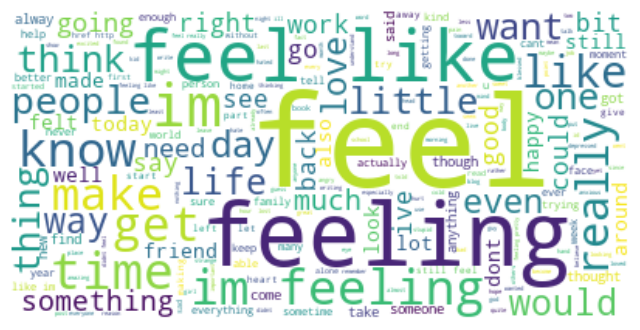

In [50]:
from wordcloud import WordCloud
text = " ".join(review for review in df.Text)
wordcloud = WordCloud(stopwords=stop_words, background_color="white").generate(text)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

<Axes: xlabel='Emotion'>

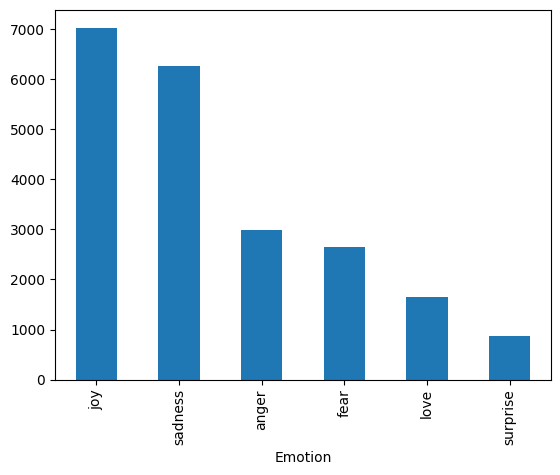

In [5]:
df.Emotion.value_counts().plot(y='Emotion',kind='bar')

In [7]:
sentences_train, sentences_test, y_train, y_test = train_test_split(df['Text'], df['Emotion'], test_size=0.20,stratify=df['Emotion'])

In [8]:
cv = CountVectorizer(lowercase = True, stop_words = stop_words, token_pattern="[A-Za-z]+")
X_train = cv.fit_transform(sentences_train)
X_test  = cv.transform(sentences_test)

In [9]:
print("taille du vocabulaire", len(cv.vocabulary_))

taille du vocabulaire 16961


In [10]:
classifier = LogisticRegression(C=1.0, max_iter=1000, random_state=42)
classifier.fit(X_train, y_train)
score = classifier.score(X_test, y_test)
print("accuracy train", classifier.score(X_train, y_train))
print("accuracy test", classifier.score(X_test, y_test))

accuracy train 0.9857284324576222
accuracy test 0.8856011183597391


In [11]:
y_pred = classifier.predict(X_test)
classification_reports = classification_report(y_test, y_pred)
print('\nClassification Report')
print('=========================================================================================')
print('\n', classification_reports)


Classification Report

               precision    recall  f1-score   support

       anger       0.88      0.85      0.86       599
        fear       0.84      0.83      0.84       530
         joy       0.90      0.94      0.92      1406
        love       0.81      0.79      0.80       328
     sadness       0.91      0.92      0.92      1253
    surprise       0.83      0.65      0.73       176

    accuracy                           0.89      4292
   macro avg       0.86      0.83      0.84      4292
weighted avg       0.88      0.89      0.88      4292



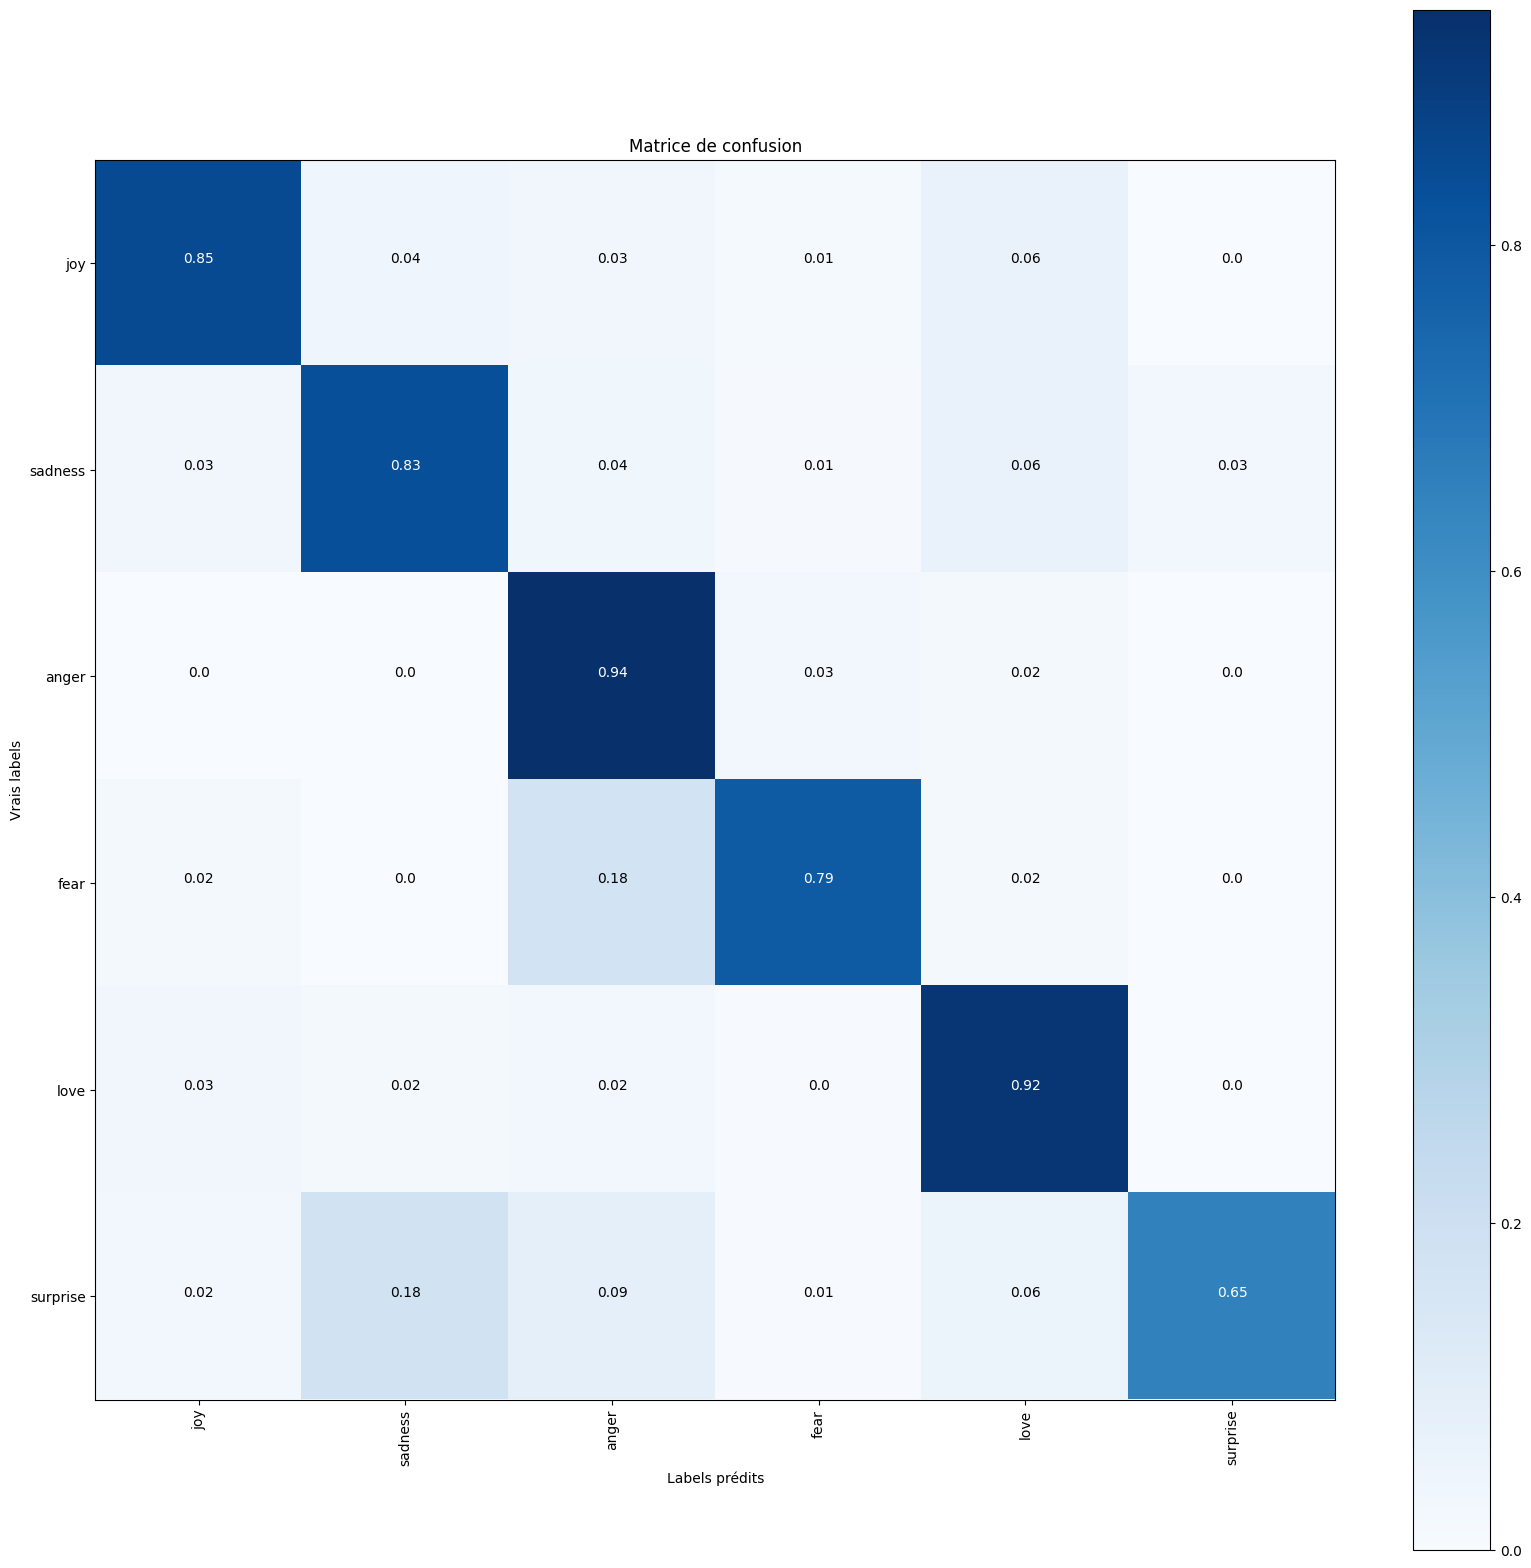

La catégorie  fear  a souvent été pris pour la catégorie  anger  ( 0.18 %)
La catégorie  surprise  a souvent été pris pour la catégorie  sadness  ( 0.18 %)
La catégorie  surprise  a souvent été pris pour la catégorie  anger  ( 0.09 %)


In [12]:
cm(y_test, y_pred)

In [13]:
lrcv = LogisticRegressionCV(cv=5, random_state=42, max_iter=1000).fit(X_train, y_train)
y_pred = pd.Series(lrcv.predict(X_test), name='nom catégorie')
classification_reports = classification_report(y_test, y_pred)
print('\nClassification Report')
print('=========================================================================================')
print('\n', classification_reports)


Classification Report

               precision    recall  f1-score   support

       anger       0.87      0.85      0.86       599
        fear       0.84      0.82      0.83       530
         joy       0.91      0.94      0.92      1406
        love       0.80      0.78      0.79       328
     sadness       0.91      0.92      0.91      1253
    surprise       0.82      0.66      0.73       176

    accuracy                           0.88      4292
   macro avg       0.86      0.83      0.84      4292
weighted avg       0.88      0.88      0.88      4292



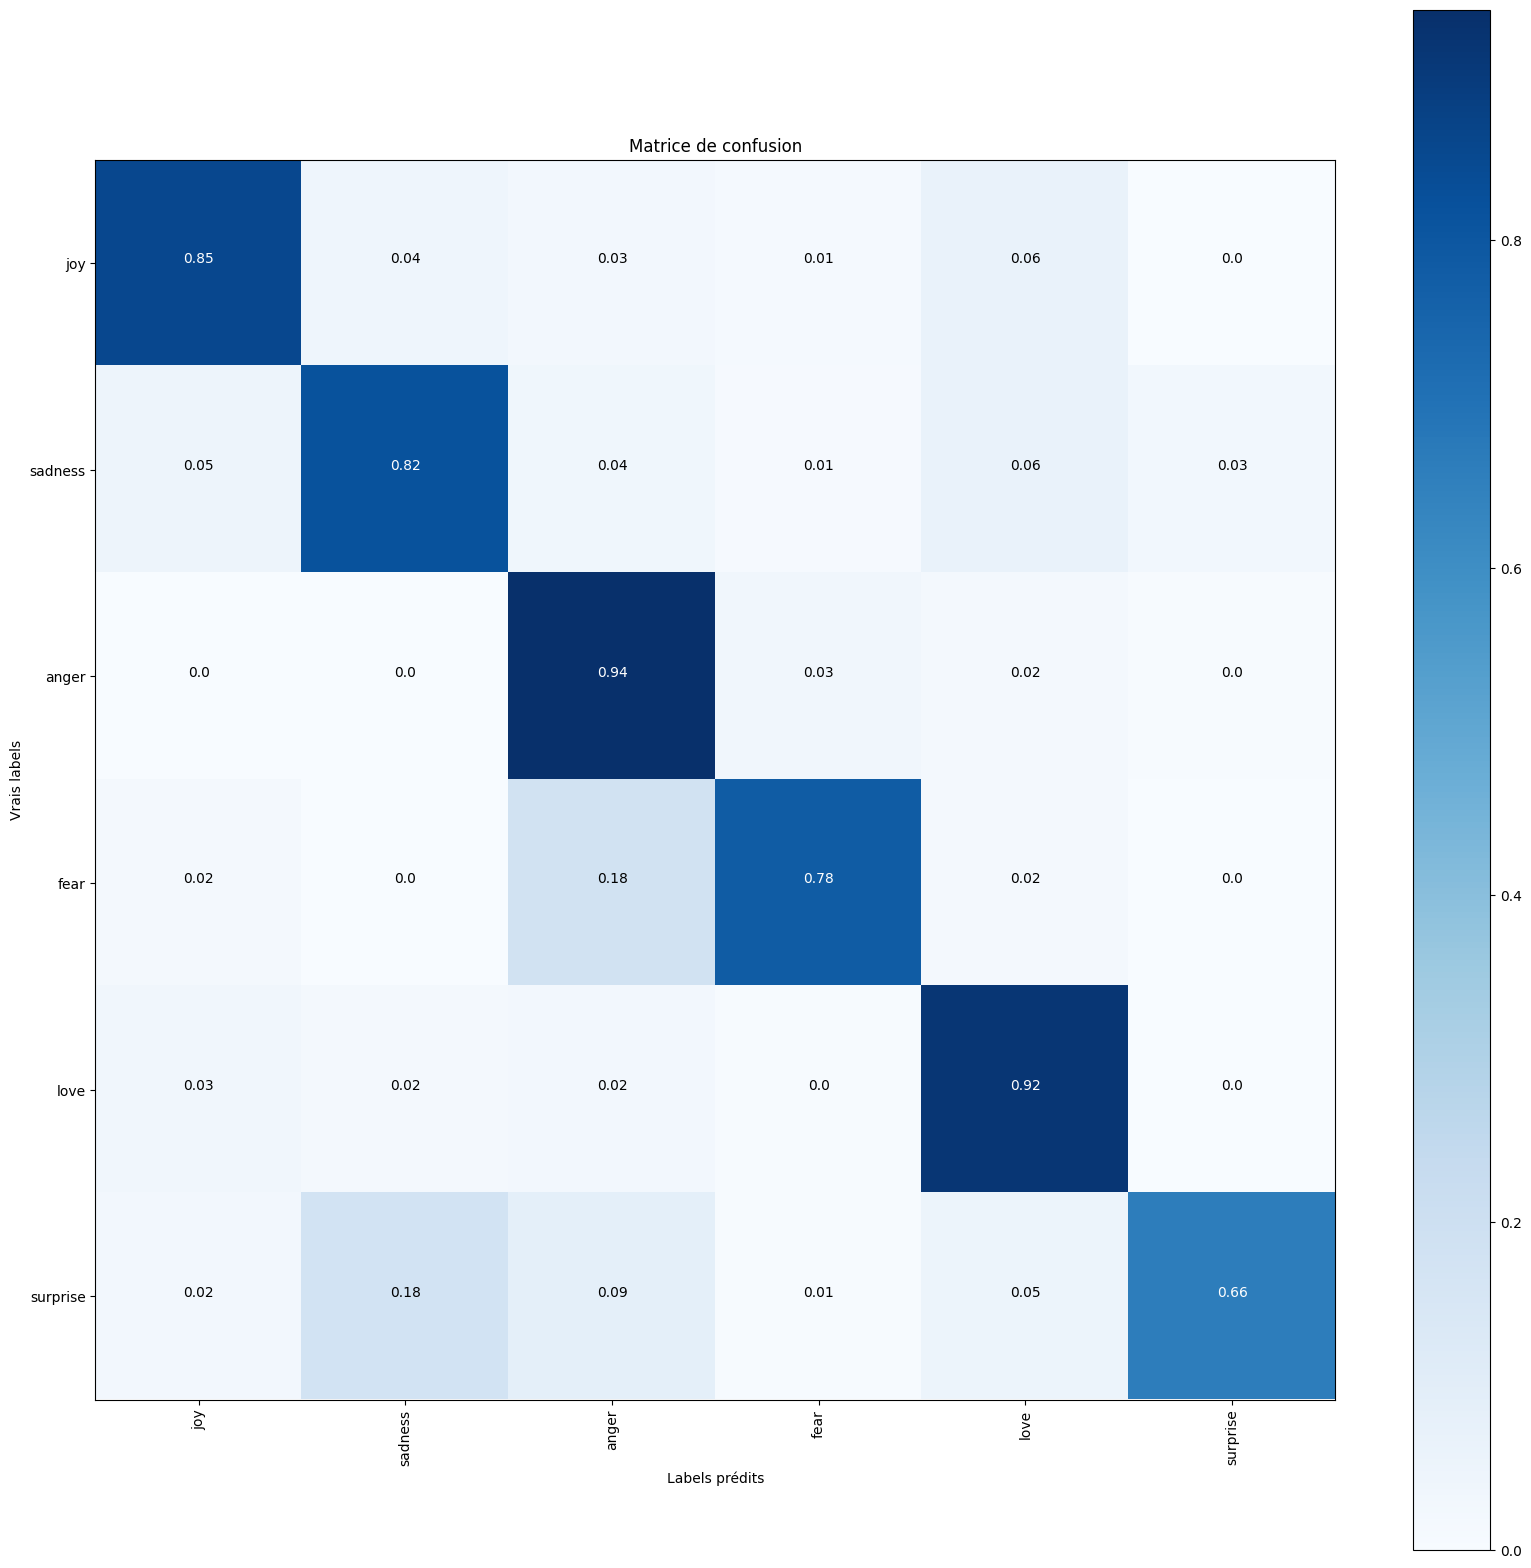

La catégorie  fear  a souvent été pris pour la catégorie  anger  ( 0.18 %)
La catégorie  surprise  a souvent été pris pour la catégorie  sadness  ( 0.18 %)
La catégorie  surprise  a souvent été pris pour la catégorie  anger  ( 0.09 %)


In [14]:
cm(y_test, y_pred)

In [15]:
td = TfidfVectorizer(max_features = 1300)
X = td.fit_transform(df['Text']).toarray()
X_train, X_test, y_train, y_test = train_test_split(X, df['Emotion'], test_size = 0.2, random_state = 42)
lrcv_tfidf = LogisticRegressionCV(cv=5, random_state=42, max_iter=2000).fit(X_train, y_train)


y_pred = pd.Series(lrcv_tfidf.predict(X_test), name='nom catégorie')
classification_reports = classification_report(y_test, y_pred)

print('\n Accuracy: ', accuracy_score(y_test, y_pred))
print('\nClassification Report')
print('=========================================================================================')
print('\n', classification_reports)


 Accuracy:  0.8525163094128612

Classification Report

               precision    recall  f1-score   support

       anger       0.89      0.78      0.83       617
        fear       0.85      0.77      0.81       531
         joy       0.84      0.92      0.88      1381
        love       0.85      0.72      0.78       318
     sadness       0.87      0.91      0.89      1277
    surprise       0.77      0.60      0.68       168

    accuracy                           0.85      4292
   macro avg       0.84      0.78      0.81      4292
weighted avg       0.85      0.85      0.85      4292



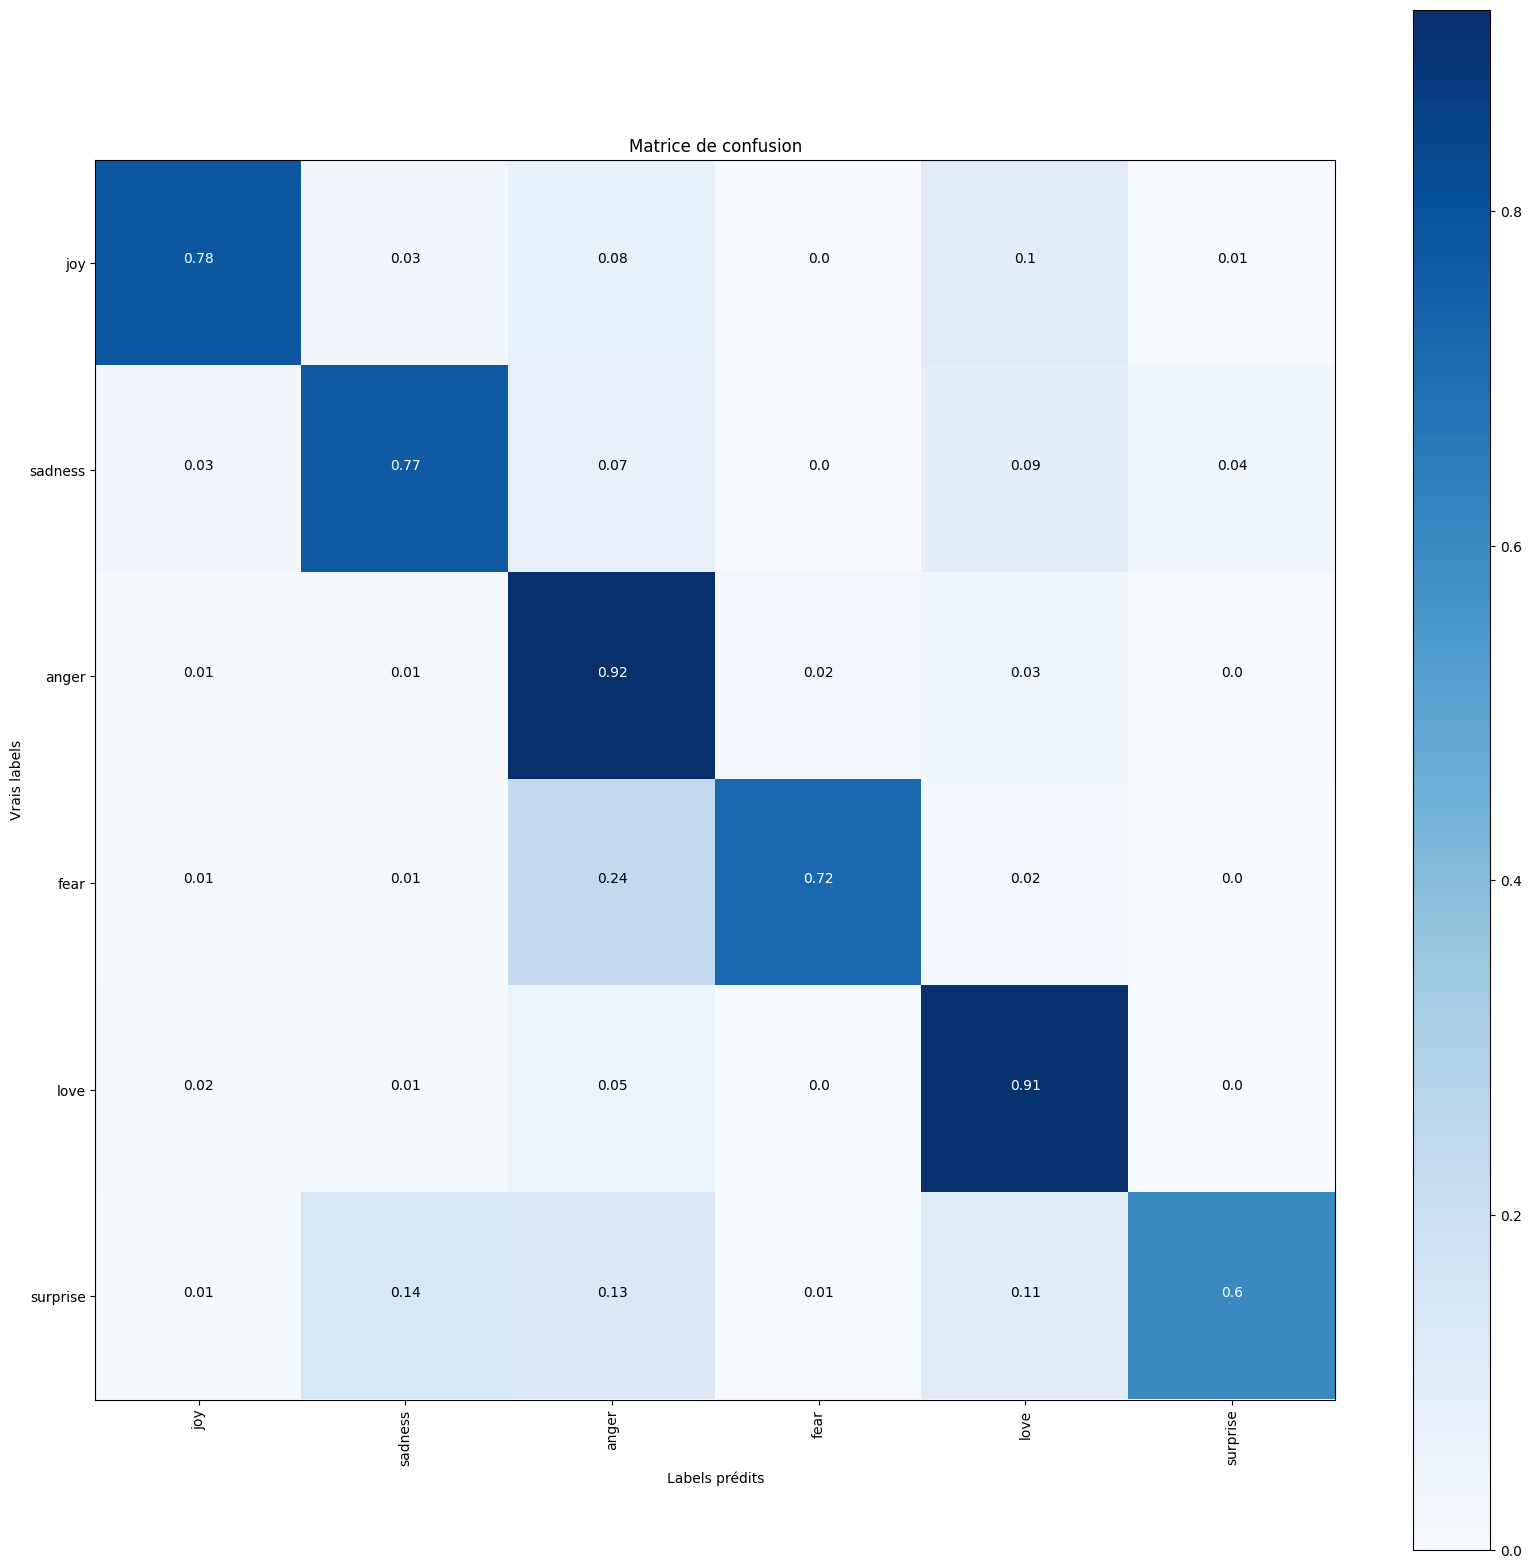

La catégorie  joy  a souvent été pris pour la catégorie  anger  ( 0.08 %)
La catégorie  joy  a souvent été pris pour la catégorie  love  ( 0.1 %)
La catégorie  sadness  a souvent été pris pour la catégorie  anger  ( 0.07 %)
La catégorie  sadness  a souvent été pris pour la catégorie  love  ( 0.09 %)
La catégorie  fear  a souvent été pris pour la catégorie  anger  ( 0.24 %)
La catégorie  surprise  a souvent été pris pour la catégorie  sadness  ( 0.14 %)
La catégorie  surprise  a souvent été pris pour la catégorie  anger  ( 0.13 %)
La catégorie  surprise  a souvent été pris pour la catégorie  love  ( 0.11 %)


In [16]:
cm(y_test, y_pred)

In [17]:
bayes = MultinomialNB()
bayes.fit(X_train, y_train)
y_pred = bayes.predict(X_test)

classification_reports = classification_report(y_test, y_pred)
print('\n Accuracy: ', accuracy_score(y_test, y_pred))
print('\nClassification Report')
print('=========================================================================================')
print('\n', classification_reports)


 Accuracy:  0.7672413793103449

Classification Report

               precision    recall  f1-score   support

       anger       0.93      0.61      0.74       617
        fear       0.86      0.57      0.69       531
         joy       0.70      0.96      0.81      1381
        love       0.98      0.31      0.47       318
     sadness       0.77      0.92      0.84      1277
    surprise       1.00      0.08      0.15       168

    accuracy                           0.77      4292
   macro avg       0.87      0.58      0.62      4292
weighted avg       0.81      0.77      0.74      4292



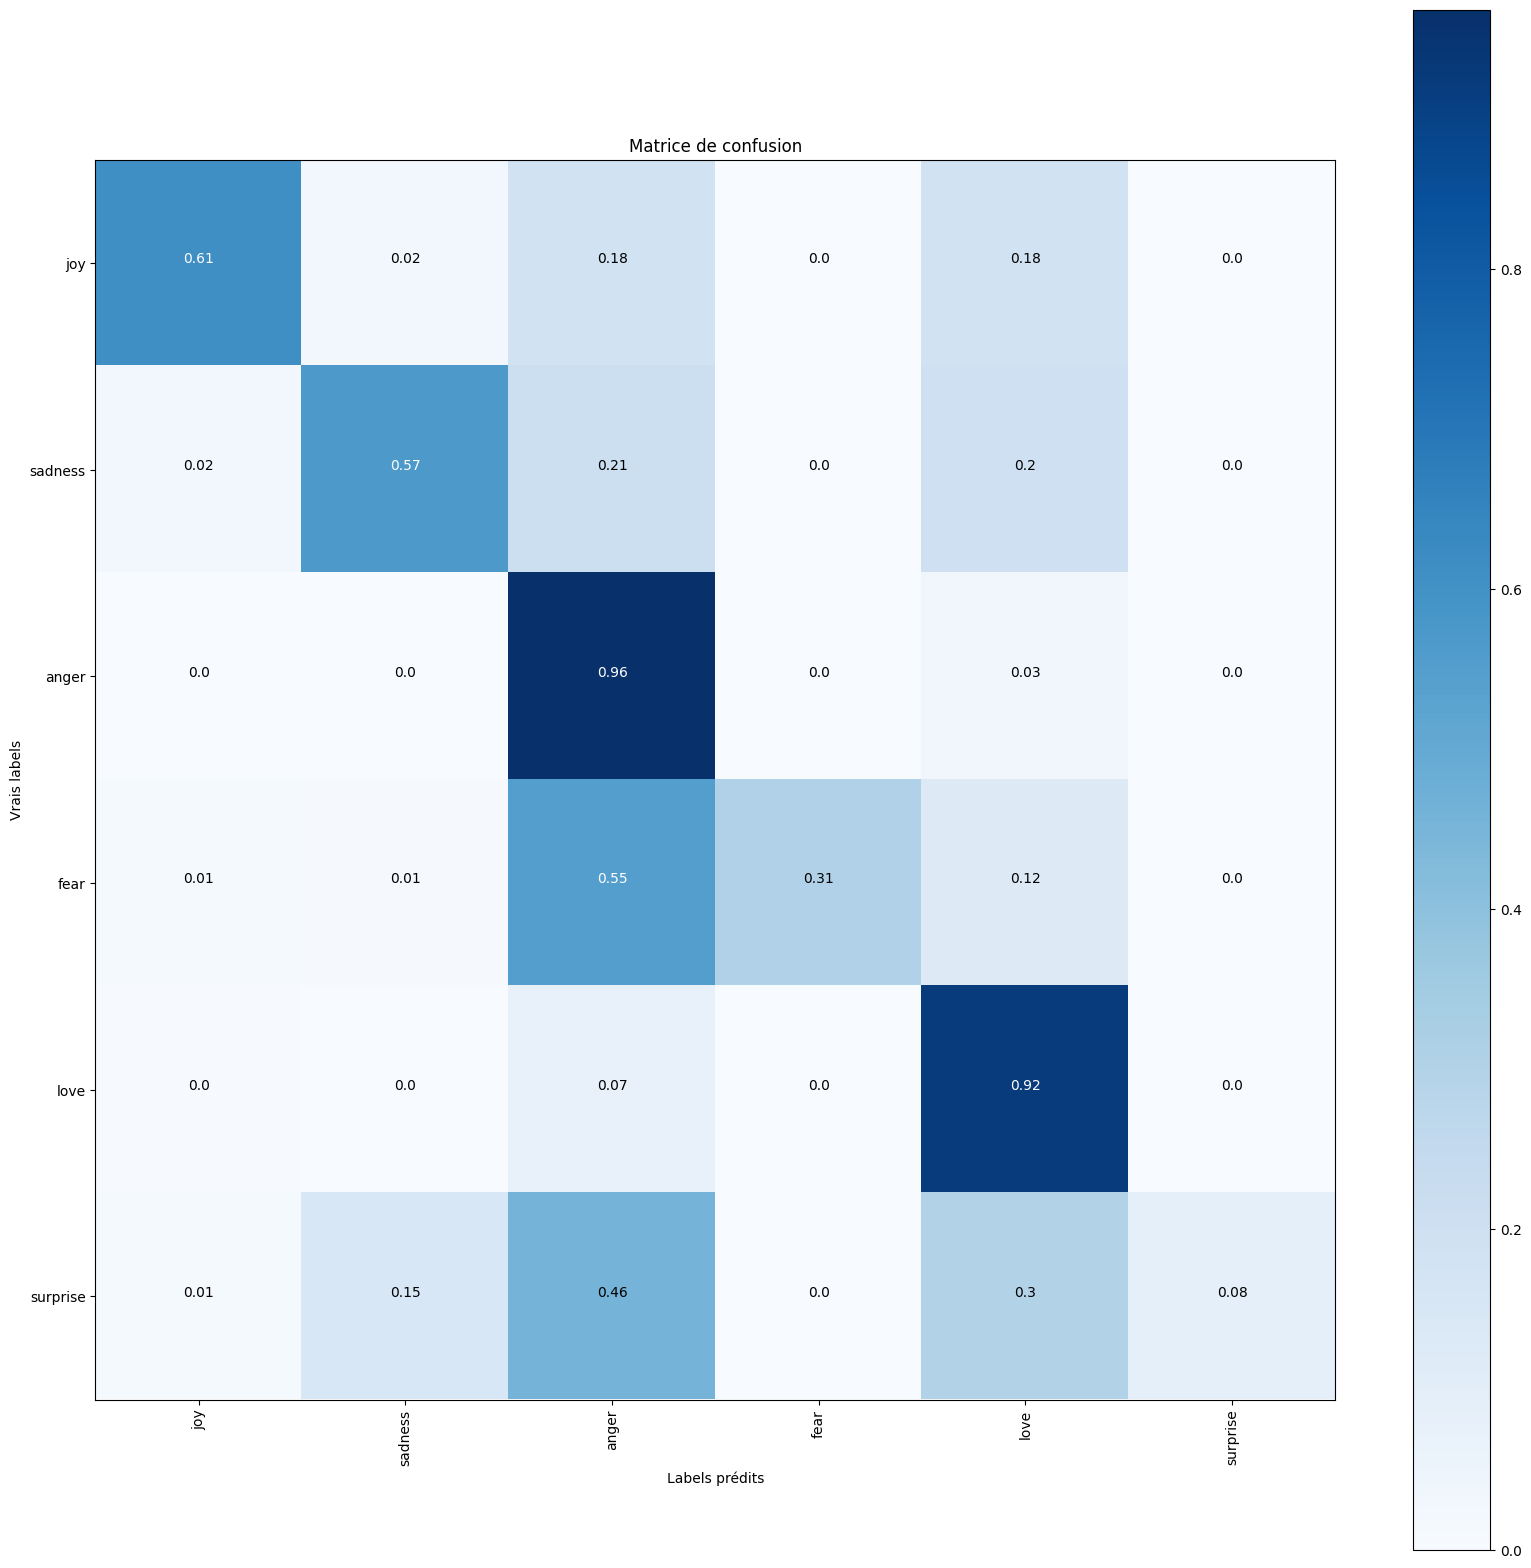

La catégorie  joy  a souvent été pris pour la catégorie  anger  ( 0.18 %)
La catégorie  joy  a souvent été pris pour la catégorie  love  ( 0.18 %)
La catégorie  sadness  a souvent été pris pour la catégorie  anger  ( 0.21 %)
La catégorie  sadness  a souvent été pris pour la catégorie  love  ( 0.2 %)
La catégorie  fear  a souvent été pris pour la catégorie  anger  ( 0.55 %)
La catégorie  fear  a souvent été pris pour la catégorie  love  ( 0.12 %)
La catégorie  love  a souvent été pris pour la catégorie  anger  ( 0.07 %)
La catégorie  surprise  a souvent été pris pour la catégorie  sadness  ( 0.15 %)
La catégorie  surprise  a souvent été pris pour la catégorie  anger  ( 0.46 %)
La catégorie  surprise  a souvent été pris pour la catégorie  love  ( 0.3 %)


In [18]:
cm(y_test, y_pred)

In [21]:
text = df['Text'].values

labels = df['Emotion'].values
encoder = LabelEncoder()
encoded_labels = encoder.fit_transform(labels)


num_classes = 6
encoded_labels = to_categorical(encoded_labels, num_classes=num_classes)


X_train, X_test, y_train, y_test = train_test_split(text, encoded_labels, test_size=0.20,stratify=encoded_labels)


tokenizer = Tokenizer(num_words=50000)
tokenizer.fit_on_texts(X_train)

X_train_tokenized = tokenizer.texts_to_sequences(X_train)
X_test_tokenized = tokenizer.texts_to_sequences(X_test)
total_words = len(tokenizer.word_index) + 1

In [22]:
maxlen_train = max([len(x) for x in X_train_tokenized])
X_train_padded = pad_sequences(X_train_tokenized, padding="post", truncating="post", maxlen=maxlen_train)
X_test_padded = pad_sequences(X_test_tokenized, padding="post", truncating="post", maxlen=maxlen_train)

In [23]:
class TimingCallback(Callback):
        def __init__(self, logs={}):
            self.logs=[]
        def on_epoch_begin(self, epoch, logs={}):
            self.starttime = timer()
        def on_epoch_end(self, epoch, logs={}):
            self.logs.append(timer()-self.starttime)



early_stopping = EarlyStopping(monitor = "val_accuracy",
                                   min_delta = 0.0002,
                                   patience = 4, 
                                   verbose = 1)


reduce_learning_rate = ReduceLROnPlateau(monitor = "val_accuracy",
                                    min_delta = 0.005,
                                    patience = 2,
                                    factor = 0.5, 
                                    cooldown = 1,
                                    verbose = 1)

save_early = ModelCheckpoint(filepath=path + "/h5/emotion.keras",
                                               verbose=1,
                                               save_best_only=True)

time_callback = TimingCallback()



callbacks_water = [early_stopping,reduce_learning_rate,save_early,time_callback]

In [24]:
model_emotion = Sequential()
model_emotion.add(Embedding(total_words, 100)) #,input_length=total_words-1
model_emotion.add(Bidirectional(LSTM(150)))
model_emotion.add(Dropout(0.2))
model_emotion.add(Dense(6, activation='softmax'))

model_emotion.summary()
model_emotion.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [25]:
model_emotion.fit(X_train_padded,y_train, epochs=5, batch_size=64)

Epoch 1/5
269/269 ━━━━━━━━━━━━━━━━━━━━ 45s 165ms/step - accuracy: 0.3891 - loss: 1.5024
Epoch 2/5
269/269 ━━━━━━━━━━━━━━━━━━━━ 58s 215ms/step - accuracy: 0.8127 - loss: 0.5229
Epoch 3/5
269/269 ━━━━━━━━━━━━━━━━━━━━ 63s 235ms/step - accuracy: 0.9437 - loss: 0.1719
Epoch 4/5
269/269 ━━━━━━━━━━━━━━━━━━━━ 63s 233ms/step - accuracy: 0.9686 - loss: 0.0971
Epoch 5/5
269/269 ━━━━━━━━━━━━━━━━━━━━ 57s 211ms/step - accuracy: 0.9710 - loss: 0.0863


In [26]:
model_emotion.evaluate(X_test_padded,y_test, batch_size=1)

4292/4292 ━━━━━━━━━━━━━━━━━━━━ 33s 8ms/step - accuracy: 0.9009 - loss: 0.3480


[0.33668991923332214, 0.8972507119178772]

In [27]:
pred = model_emotion.predict(X_test_padded, verbose = 1)

135/135 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step


In [28]:
y_train_num=pd.get_dummies(df["Emotion"])

y_pred = pd.DataFrame(pred,columns = y_train_num.columns).idxmax(axis = 1)
y_true = pd.DataFrame(y_test,columns = y_train_num.columns).idxmax(axis = 1)


In [29]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

       anger       0.95      0.82      0.88       599
        fear       0.81      0.89      0.85       530
         joy       0.91      0.93      0.92      1406
        love       0.82      0.84      0.83       328
     sadness       0.94      0.93      0.93      1253
    surprise       0.76      0.79      0.77       176

    accuracy                           0.90      4292
   macro avg       0.87      0.87      0.86      4292
weighted avg       0.90      0.90      0.90      4292



In [34]:
from pycaret.classification import *

In [36]:
cv = CountVectorizer(lowercase = True, stop_words = stop_words, token_pattern="[A-Za-z]+")

In [39]:
Data = cv.fit_transform(df['Text'])
Data_df = pd.DataFrame(Data.toarray(), columns=cv.get_feature_names_out())
Data_df['Emotion'] = df.reset_index().Emotion.map({'joy':0, 'sadness':1, 'anger':2, 'fear':3, 'love':4, 'surprise':5})

,aa,aaaaaaand,aaaaand,aaaah,aaaand,aac,aahhh,aaron,ab,abandon,...,zoom,zooming,zooms,zq,zucchini,zum,zumba,zz,zzap,Emotion
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21454,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
21455,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
21456,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
21457,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3


In [41]:
setup = setup(data=Data_df, target='Emotion', session_id=123, train_size = 0.7, fold=10)

,Description,Value
0,Session id,123
1,Target,Emotion
2,Target type,Multiclass
3,Original data shape,"(21459, 19038)"
4,Transformed data shape,"(21459, 19038)"
5,Transformed train set shape,"(15021, 19038)"
6,Transformed test set shape,"(6438, 19038)"
7,Numeric features,19037
8,Preprocess,True
9,Imputation type,simple


In [42]:
models = compare_models()

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,12:38:13
Status,. . . . . . . . . . . . . . . . . .,Fitting 10 Folds
Estimator,. . . . . . . . . . . . . . . . . .,Linear Discriminant Analysis


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
ridge,Ridge Classifier,0.8892,0.0000,0.8892,0.8891,0.8888,0.8548,0.8549,17.6730
svm,SVM - Linear Kernel,0.8838,0.0000,0.8838,0.8837,0.8832,0.8477,0.8479,6.1310
lr,Logistic Regression,0.8818,0.0000,0.8818,0.8809,0.8805,0.8445,0.8448,38.6940
rf,Random Forest Classifier,0.8763,0.9870,0.8763,0.8774,0.8764,0.8384,0.8385,7.0230
dt,Decision Tree Classifier,0.8633,0.9164,0.8633,0.8653,0.8638,0.8220,0.8223,6.6340
gbc,Gradient Boosting Classifier,0.8203,0.0000,0.8203,0.8436,0.8205,0.7605,0.7691,71.0780
knn,K Neighbors Classifier,0.5434,0.7921,0.5434,0.5523,0.5157,0.3703,0.3794,10.5790
nb,Naive Bayes,0.3787,0.6199,0.3787,0.4383,0.3926,0.2294,0.2338,5.1580
ada,Ada Boost Classifier,0.3504,0.0000,0.3504,0.2880,0.2491,0.0565,0.0855,21.2820
qda,Quadratic Discriminant Analysis,0.1871,0.0000,0.1871,0.4109,0.2239,0.0787,0.1091,38.0890


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

KeyboardInterrupt: 

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8762,0.0000,0.8762,0.8757,0.8753,0.8373,0.8376
1,0.8675,0.0000,0.8675,0.8666,0.8660,0.8254,0.8259
2,0.8788,0.0000,0.8788,0.8772,0.8773,0.8405,0.8408
3,0.8722,0.0000,0.8722,0.8709,0.8705,0.8316,0.8319
4,0.8888,0.0000,0.8888,0.8889,0.8874,0.8532,0.8539
5,0.8842,0.0000,0.8842,0.8827,0.8824,0.8474,0.8478
6,0.8808,0.0000,0.8808,0.8792,0.8792,0.8432,0.8435
7,0.8822,0.0000,0.8822,0.8816,0.8816,0.8456,0.8457
8,0.8888,0.0000,0.8888,0.8877,0.8875,0.8537,0.8540


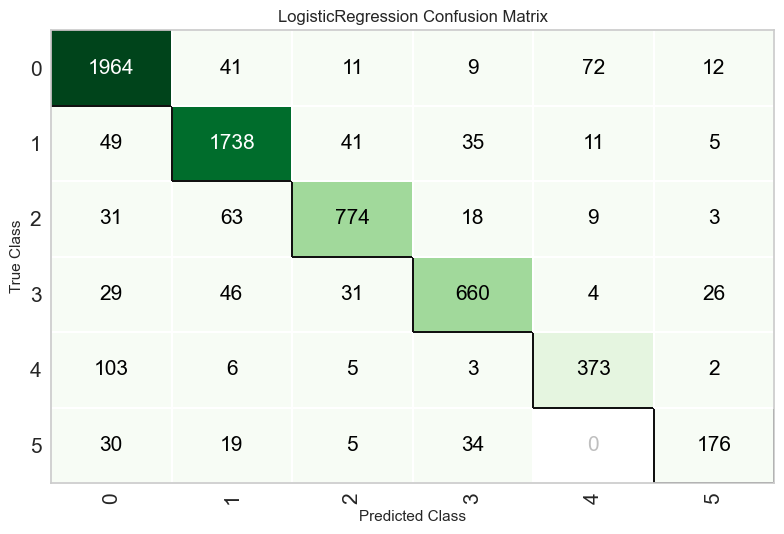

In [43]:
lr = create_model('lr')
plot_model(lr, "confusion_matrix")